# Problem set 3. Transitions for Hugget: Debt and Pareto Improvements
Manuel Amador

Julia 1.8.5 



In [1]:
import Pkg
Pkg.activate(@__DIR__)  # Activate a local environment 
Pkg.instantiate()  # Install dependencies
using CairoMakie  # using Makie for plots. You could instead use Plot

  Activating project at `c:\Users\amador\Dropbox\Teaching\mn grad\mn 8108 Winter 2025\problem sets\PSET 3`
┌ Warning: The active manifest file has dependencies that were resolved with a different julia version (1.8.5). Unexpected behavior may occur.
└ @ nothing C:\Users\amador\Dropbox\Teaching\mn grad\mn 8108 Winter 2025\problem sets\PSET 3\Manifest.toml:0


In [2]:
Base.@kwdef struct Household{T1, T2, T3, R1, S}
    β::R1 = 0.95
    ρ::R1 = 2.0 
    ϕ::R1 = 0.0  # The borrowing limit is zero 
    P::T1 = [0.5 0.5; 0.2 0.8]
    y::T2 = [0.5, 1.0]
    a_min::R1 = ϕ
    a_max::R1 = 5.0
    points::S = 10_000
    
    a_grid::T3 = range(a_min, a_max, points)
end

u(c, m) = c ^ (1 - m.ρ) / (1 - m.ρ)  
uprime(c, m) = c ^ (-m.ρ) 

uprime (generic function with 1 method)

In [3]:
function solve_household(h, R; v0 = zeros(length(h.a_grid), length(h.y)),  tol = 1e-6)

    # unpacking 
    (; a_grid, y, β, P) = h
    
    v1 = similar(v0)
    pol = similar(v0, Int)
    βv = similar(v1)
    
    n = length(a_grid)
    
    iter = 0
    @inbounds while true
        distance = zero(eltype(v0))
        iter += 1 
                
        for s in eachindex(y)
            for i in eachindex(a_grid)
                accum = zero(eltype(v0))
                for sprime in eachindex(y)
                    accum += β * P[s, sprime] * v0[i, sprime]
                end
                βv[i, s] = accum
            end 
        end

        for s in eachindex(y) 
            pol_i = 1
            for i in eachindex(a_grid)
                just_started = true 
                vmax = zero(eltype(v0))
                for j in pol_i:n
                    c = R * a_grid[i] + y[s] - a_grid[j]
                    if c > 0
                        v_tmp = u(c, h) + βv[j, s]
                        if just_started
                            vmax = v_tmp
                            pol_i = j
                            just_started = false
                        elseif v_tmp > vmax 
                            vmax = v_tmp 
                            pol_i = j
                        else 
                            break 
                        end 
                    end 
                end 
                v1[i, s] = vmax
                pol[i, s] = pol_i
                dis = abs(vmax - v0[i, s])
                if dis > distance
                    distance = dis
                end 
            end 
        end 
        
        # mod(iter, 100) == 1 && println(iter, " ", distance)
        if distance < tol
            break
        else 
            v0, v1 = v1, v0 
        end 
    end 
    return (v = v1, pol = pol, h = h, R = R)
end 
    

solve_household (generic function with 1 method)

In [4]:
function compute_stationary_distribution(sol; tol = 1e-7, init_pdf = fill(1.0 / prod(size(sol.v)), size(sol.v)) )
    (; pol, h, R) = sol
    
    pdf_0 = copy(init_pdf)
    pdf_1 = similar(init_pdf)
    
    while true 
        fill!(pdf_1, zero(eltype(pdf_0)))
        
        for i in eachindex(h.a_grid)
            for s in eachindex(h.y)
                for sprime in eachindex(h.y)
                    pdf_1[pol[i, s], sprime] += h.P[s, sprime] * pdf_0[i, s]
                end
            end 
        end
        
        distance = zero(eltype(pdf_0))
        for (a, b) in zip(pdf_0, pdf_1)
            distance = max(abs(a - b), distance)
        end
        
        (distance < tol) && break 
        pdf_0, pdf_1 = pdf_1, pdf_0
    end 
    return pdf_1
end 

compute_stationary_distribution (generic function with 1 method)

In [5]:
function do_pdf_plot(sol, pdf)
    fig = Figure()
    lines(fig[1, 1], sol.h.a_grid, sum(pdf, dims = 2)[:, 1], axis = (title = "PDF", ))
    return fig
end

function do_cdf_plot(sol, pdf) 
    fig = Figure()
    lines(fig[1, 1], sol.h.a_grid, cumsum(sum(pdf, dims = 2)[:, 1]), axis = (title = "CDF", ))
    return fig
end

do_cdf_plot (generic function with 1 method)

In [6]:
function find_R_bar(h)
    (; y, β, P) = h
    # You need to compute the code for Rbar
end

find_R_bar (generic function with 1 method)

In [7]:
h = Household()
Rbar = 0.5  #  = find_R_bar(h)  # PLACEHOLDER: You need to compute Rbar. 
solA = solve_household(h,  Rbar)
println("Rbar = ", solA.R)

# new steady state with higher R' = 1 
solB = solve_household(h, 1.0);

Rbar = 0.5


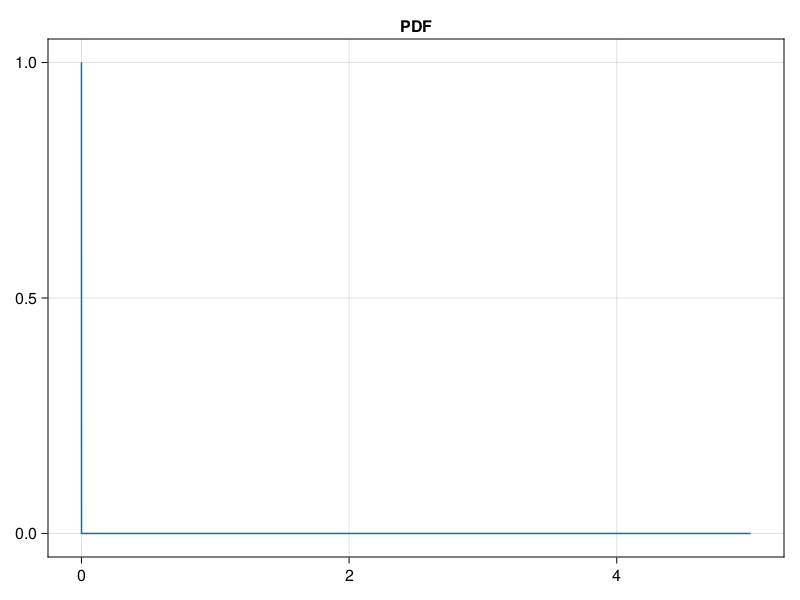

In [8]:
do_pdf_plot(solA, compute_stationary_distribution(solA))

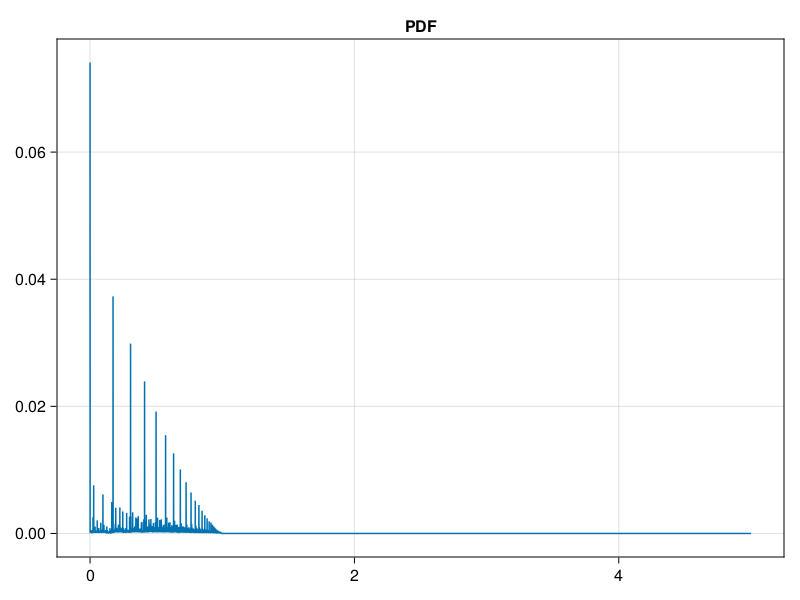

In [9]:
do_pdf_plot(solA, compute_stationary_distribution(solB))